In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
sns.set_style("whitegrid")

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

from mr import utils
from mr.models.baseline import BaselineModel
from mr.models.knn import KNN
from mr.models.funk_svd import FunkSVD
from mr.models.neural_collaborative_filtering import NCF

In [2]:
train_filename = 'ml_small_tr.npy'
test_filename = 'ml_small_te.npy'
row_count = 610
col_count = 9724

data_train = np.load(train_filename)
data_test = np.load(test_filename)

In [3]:
data_train.shape[0] + data_test.shape[0]

100836

In [4]:
# --- BASELINE MODEL ---
X_train = data_train[:, :2].astype(int)
y_train = data_train[:, 2]
X_test = data_test[:, :2].astype(int)
y_test = data_test[:, 2]

# Training

mdl = BaselineModel(row_count=row_count, col_count=col_count)
mdl.fit(X_train, y_train)

# Testing (No tuning needed for the baseline model)

prediction_mode_lst = ['mean', 'row_mean', 'col_mean', 'row_col_mean']

for mode in prediction_mode_lst:
    mdl.prediction_mode = mode
    y_predict = mdl.predict(X_test)
    rmse = utils.compute_rmse(y_test, y_predict)
    print('RMSE using {} prediction mode: {:.5f}'.format(mode, rmse))

RMSE using mean prediction mode: 1.04116
RMSE using row_mean prediction mode: 0.94175
RMSE using col_mean prediction mode: 0.97405
RMSE using row_col_mean prediction mode: 0.91125


In [4]:
data_train, data_valid = utils.shuffle_split(data_train, 0.75)
data_valid = utils.sort_nonzero_order(data_valid)

X_train = data_train[:, :2].astype(int)
y_train = data_train[:, 2]
X_valid = data_valid[:, :2].astype(int)
y_valid = data_valid[:, 2]

In [6]:
# --- KNN MODEL ---

for k in [1, 4, 8, 16, 32, 64]:
    mdl = KNN(row_count=row_count, col_count=col_count, K=k, prediction_mode='all')
    mdl.fit(X_train, y_train)
    y_predict_simple, y_predict_weighted, y_predict_baseline = mdl.predict(X_valid)
    
    rmse = utils.compute_rmse(y_valid, y_predict_simple)
    print('RMSE of KNN with K = {} using simple-average: {:.5f}: '.format(k, rmse))
    
    rmse = utils.compute_rmse(y_valid, y_predict_weighted)
    print('RMSE of KNN with K = {} using weighted-average: {:.5f}: '.format(k, rmse))
    
    rmse = utils.compute_rmse(y_valid, y_predict_baseline)
    print('RMSE of KNN with K = {} using baseline-considered-average: {:.5f}: '.format(k, rmse))

/home/seljuk/Desktop/eee585/project/eee-585-project/mr/models/knn.py:61: RuntimeWarning: invalid value encountered in true_divide
  col_deviation = self.X_train_csr.sum(axis=0).A1 / self.X_train_csr.getnnz(axis=0) - overall_mean


RMSE of KNN with K = 1 using simple-average: 1.22049: 
RMSE of KNN with K = 1 using weighted-average: 1.21867: 
RMSE of KNN with K = 1 using baseline-considered-average: 1.11583: 
RMSE of KNN with K = 4 using simple-average: 1.00953: 
RMSE of KNN with K = 4 using weighted-average: 1.02014: 
RMSE of KNN with K = 4 using baseline-considered-average: 0.93873: 
RMSE of KNN with K = 8 using simple-average: 0.98201: 
RMSE of KNN with K = 8 using weighted-average: 0.99390: 
RMSE of KNN with K = 8 using baseline-considered-average: 0.91510: 
RMSE of KNN with K = 16 using simple-average: 0.97288: 
RMSE of KNN with K = 16 using weighted-average: 0.98448: 
RMSE of KNN with K = 16 using baseline-considered-average: 0.90744: 
RMSE of KNN with K = 32 using simple-average: 0.97401: 
RMSE of KNN with K = 32 using weighted-average: 0.98317: 
RMSE of KNN with K = 32 using baseline-considered-average: 0.90692: 
RMSE of KNN with K = 64 using simple-average: 0.97538: 
RMSE of KNN with K = 64 using weighted

0.8939990258711411


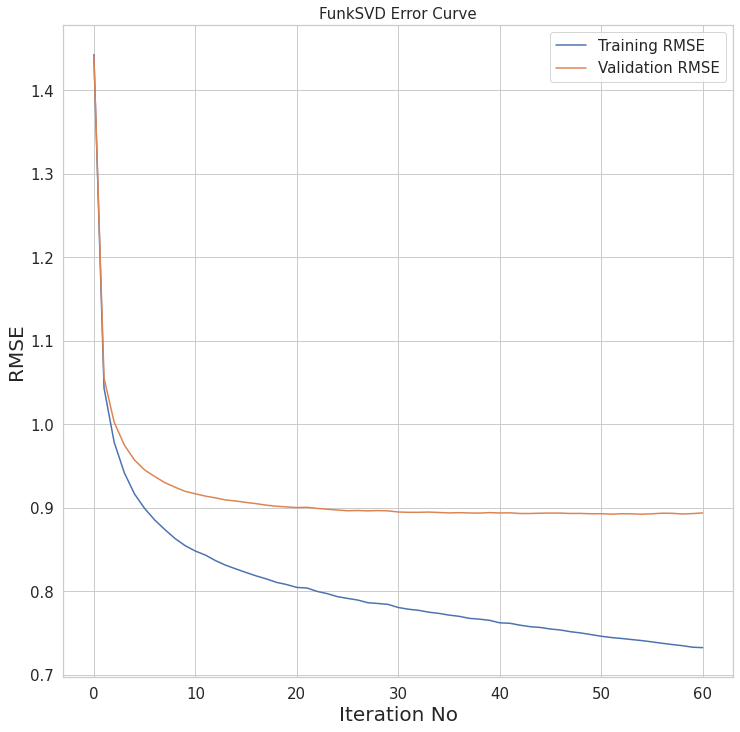

In [6]:
# --- FUNK SVD MODEL PLOT ERROR ---

validation_tuple = (X_valid, y_valid)

conf = {'factor_size': 16, 'iteration_count': 60, 'alpha': 0.003, 'beta': 0.1}

mdl = FunkSVD(row_count=row_count, col_count=col_count, **conf)
mdl.fit(X_train, y_train, validation_tuple=validation_tuple)
y_predict = mdl.predict(X_valid)

rmse = utils.compute_rmse(y_valid, y_predict)
print(rmse)

train_error = mdl._train_loss
valid_error = mdl._valid_loss

plt.plot(np.arange(len(train_error)), train_error, label='Training RMSE')
plt.plot(np.arange(len(valid_error)), valid_error, label='Validation RMSE')

plt.xlabel('Iteration No')
plt.ylabel('RMSE')
plt.title('FunkSVD Error Curve')

plt.legend()
plt.show()

In [7]:
# --- FUNK SVD GRID SEARCH ---

conf_lst = []
conf_lst.append({'factor_size':16, 'iteration_count':60, 'alpha':0.003, 'beta':0.2})
conf_lst.append({'factor_size':16, 'iteration_count':60, 'alpha':0.003, 'beta':0.1})
conf_lst.append({'factor_size':16, 'iteration_count':60, 'alpha':0.003, 'beta':0.5})
conf_lst.append({'factor_size':16, 'iteration_count':30, 'alpha':0.003, 'beta':0.2})
conf_lst.append({'factor_size':32, 'iteration_count':60, 'alpha':0.003, 'beta':0.2})
conf_lst.append({'factor_size':64, 'iteration_count':60, 'alpha':0.003, 'beta':0.2})
conf_lst.append({'factor_size':128, 'iteration_count':60, 'alpha':0.003, 'beta':0.2})
conf_lst.append({'factor_size':8, 'iteration_count':60, 'alpha':0.003, 'beta':0.2})
conf_lst.append({'factor_size':16, 'iteration_count':60, 'alpha':0.001, 'beta':0.2})
conf_lst.append({'factor_size':16, 'iteration_count':60, 'alpha':0.01, 'beta':0.2})
conf_lst.append({'factor_size':16, 'iteration_count':60, 'alpha':0.01, 'beta':0.02})

for conf in conf_lst:
    mdl = FunkSVD(row_count=row_count, col_count=col_count, **conf)
    print('RMSE of Funk-SVD using the following configuration')
    print(conf)
    mdl.fit(X_train, y_train)
    
    y_predict = mdl.predict(X_valid)
    rmse = utils.compute_rmse(y_valid, y_predict)
    print(rmse)
    print()

RMSE of Funk-SVD using the following configuration
{'factor_size': 16, 'iteration_count': 60, 'alpha': 0.003, 'beta': 0.2}
0.9070239368719795

RMSE of Funk-SVD using the following configuration
{'factor_size': 16, 'iteration_count': 60, 'alpha': 0.003, 'beta': 0.1}
0.8977231668325812

RMSE of Funk-SVD using the following configuration
{'factor_size': 16, 'iteration_count': 60, 'alpha': 0.003, 'beta': 0.5}
1.0016215146239797

RMSE of Funk-SVD using the following configuration
{'factor_size': 16, 'iteration_count': 30, 'alpha': 0.003, 'beta': 0.2}
0.9080745609523971

RMSE of Funk-SVD using the following configuration
{'factor_size': 32, 'iteration_count': 60, 'alpha': 0.003, 'beta': 0.2}
0.9501169950807493

RMSE of Funk-SVD using the following configuration
{'factor_size': 64, 'iteration_count': 60, 'alpha': 0.003, 'beta': 0.2}
1.0225245050894296

RMSE of Funk-SVD using the following configuration
{'factor_size': 128, 'iteration_count': 60, 'alpha': 0.003, 'beta': 0.2}
1.041153849103004


In [ ]:
# --- NCF MODEL PLOT ERROR ---

factor_size = 16
iteration_count = 100
lr = 0.001
layers=(32, 16)

mdl = NCF(row_count=row_count, col_count=col_count, factor_size=factor_size, layers=layers,
          iteration_count=iteration_count, lr=lr)
mdl.fit(X_train, y_train, validation_tuple=(X_valid, y_valid))
y_predict = mdl.predict(X_valid)

rmse = utils.compute_rmse(y_valid, y_predict)
print(rmse)

train_error = mdl._train_loss
valid_error = mdl._valid_loss

plt.plot(np.arange(len(train_error)), train_error, label='Training RMSE')
plt.plot(np.arange(len(valid_error)), valid_error, label='Validation RMSE')

plt.xlabel('Iteration No')
plt.ylabel('RMSE')
plt.title('FunkSVD Error Curve')

plt.legend()
plt.show()

In [8]:
# --- NCF GRID SEARCH ---

conf_lst = []
conf_lst.append({'factor_size':16, 'iteration_count':60, 'lr':0.001, 'layers':(32, 16)})
conf_lst.append({'factor_size':16, 'iteration_count':60, 'lr':0.01, 'layers':(32, 16)})
conf_lst.append({'factor_size':16, 'iteration_count':60, 'lr':0.001, 'layers':(32, 64, 64)})
conf_lst.append({'factor_size':16, 'iteration_count':60, 'lr':0.01, 'layers':(32, 64, 64)})
conf_lst.append({'factor_size':32, 'iteration_count':60, 'lr':0.001, 'layers':(64, 64)})
conf_lst.append({'factor_size':32, 'iteration_count':60, 'lr':0.001, 'layers':(64, 64, 64)})
conf_lst.append({'factor_size':16, 'iteration_count':60, 'lr':0.001, 'layers':(32, 32, 16, 16)})
conf_lst.append({'factor_size':128, 'iteration_count':60, 'lr':0.001, 'layers':(256, 64)})
conf_lst.append({'factor_size':128, 'iteration_count':60, 'lr':0.005, 'layers':(256, 64)})
conf_lst.append({'factor_size':128, 'iteration_count':60, 'lr':0.0005, 'layers':(256, 64)})
conf_lst.append({'factor_size':8, 'iteration_count':60, 'lr':0.001, 'layers':(16, 16)})

for conf in conf_lst:
    mdl = NCF(row_count=row_count, col_count=col_count, **conf)
    print('RMSE of Funk-SVD using the following configuration')
    print(conf)
    mdl.fit(X_train, y_train)
    
    y_predict = mdl.predict(X_valid)
    rmse = utils.compute_rmse(y_valid, y_predict)
    print(rmse)
    print()

RMSE of Funk-SVD using the following configuration
{'factor_size': 16, 'iteration_count': 60, 'lr': 0.001, 'layers': (32, 16)}
0.8934280587339868

RMSE of Funk-SVD using the following configuration
{'factor_size': 16, 'iteration_count': 60, 'lr': 0.01, 'layers': (32, 16)}
0.8900011026471939

RMSE of Funk-SVD using the following configuration
{'factor_size': 16, 'iteration_count': 60, 'lr': 0.001, 'layers': (32, 64, 64)}
0.8951114420885119

RMSE of Funk-SVD using the following configuration
{'factor_size': 16, 'iteration_count': 60, 'lr': 0.01, 'layers': (32, 64, 64)}


/home/seljuk/Desktop/eee585/project/eee-585-project/mr/models/neural_collaborative_filtering.py:46: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-1 * x))


0.9005806882247799

RMSE of Funk-SVD using the following configuration
{'factor_size': 32, 'iteration_count': 60, 'lr': 0.001, 'layers': (64, 64)}
0.8986185582538498

RMSE of Funk-SVD using the following configuration
{'factor_size': 32, 'iteration_count': 60, 'lr': 0.001, 'layers': (64, 64, 64)}
0.8924760894728625

RMSE of Funk-SVD using the following configuration
{'factor_size': 16, 'iteration_count': 60, 'lr': 0.001, 'layers': (32, 32, 16, 16)}
0.9082644697996134

RMSE of Funk-SVD using the following configuration
{'factor_size': 128, 'iteration_count': 60, 'lr': 0.001, 'layers': (256, 64)}
0.9026112105146096

RMSE of Funk-SVD using the following configuration
{'factor_size': 128, 'iteration_count': 60, 'lr': 0.005, 'layers': (256, 64)}
0.8977943512344648

RMSE of Funk-SVD using the following configuration
{'factor_size': 128, 'iteration_count': 60, 'lr': 0.0005, 'layers': (256, 64)}
0.8933919500676616

RMSE of Funk-SVD using the following configuration
{'factor_size': 8, 'iteratio